In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import pipeline

In [2]:
df = pd.read_pickle("reviews.pkl")

In [3]:
def preprocessing(df):
    df.drop(
        columns=[
            "images",
            "language",
            "url",
            "userId",
            "index",
            "restaurantId",
            "reviewId",
        ],
        inplace=True,
    )
    df["date"] = df["date"].apply(lambda x: x.split()[::2])
    mes = {
        "enero": "01",
        "febrero": "02",
        "marzo": "03",
        "abril": "04",
        "mayo": "05",
        "junio": "06",
        "julio": "07",
        "agosto": "08",
        "septiembre": "09",
        "octubre": "10",
        "noviembre": "11",
        "diciembre": "12",
    }
    df["mes"] = df["date"].apply(lambda x: mes[x[1]])
    df["date"] = df[["date", "mes"]].apply(
        lambda x: str(x[0][0]) + "-" + str(x[1]) + "-" + str(x[0][2]), axis=1
    )
    df.drop(columns=["mes"], inplace=True)
    df["date"] = pd.to_datetime(df["date"])
    return df

In [4]:
df = preprocessing(df)

C:\Users\jilai\AppData\Local\Temp\ipykernel_14612\3951252518.py:34: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["date"] = pd.to_datetime(df["date"])


In [5]:
from transformers import pipeline

distilled_student_sentiment_classifier = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student", 
    return_all_scores=True
)

c:\Users\jilai\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [6]:
def get_higher_sentiment_score(sentiment_scores):
    max = [(scores["score"], scores["label"]) for scores in sentiment_scores[0]]
    max.sort(reverse=True)
    return max[0][1]


In [7]:
"""
df2 = df.copy().iloc[:1000]
df2["sentiment"] = df2["text"].apply(lambda x: get_higher_sentiment_score(distilled_student_sentiment_classifier(x)))
df2.to_pickle("reviews_with_sentiment.pkl")
"""

'\ndf2 = df.copy().iloc[:1000]\ndf2["sentiment"] = df2["text"].apply(lambda x: get_higher_sentiment_score(distilled_student_sentiment_classifier(x)))\ndf2.to_pickle("reviews_with_sentiment.pkl")\n'

In [8]:
df2 = pd.read_pickle("reviews_with_sentiment.pkl")

In [9]:
df2["rating-sentiment"] = df2[["rating", "sentiment"]].apply(lambda x: 1 if (x[0] > 30 and x[1] == "positive") or (x[0] == 30 and x[1]=="neutral") or (x[0] < 30 and x[1]=="negative") else 0, axis=1)

In [10]:
df2.head()

,date,rating,text,title,sentiment,rating-sentiment
0,2017-04-26,30,"Si quieres comer abundante, bien y sin floritu...",Comida casera muy casera,positive,0
1,2015-08-17,40,cerveceria calsica muy cerquita de la plaza ma...,clasica cerveceria cons sabor autentico,positive,1
2,2018-04-27,50,Una amiga que vive en alameda de Osuna juraba ...,Pasteles increíbles,positive,1
3,2018-04-15,40,"la bolleria genial, el cafe bueno, el personal...",una buena merienda,positive,1
4,2017-12-31,50,Impecable servicio y la mejor calidad y sabor ...,Excelente,positive,1


In [11]:
# Load the regular expression library
import re# Remove punctuation
df2['text_processed'] = \
df2['text'].map(lambda x: re.sub('[,\.!?]', '', x))# Convert the titles to lowercase
df2['text_processed'] = \
df2['text_processed'].map(lambda x: x.lower())# Print out the first rows of papers
df2['text_processed'].head()

# Remove stop words
from nltk.corpus import stopwords
stop_words = set(stopwords.words('spanish'))# Function to remove stop words from sentences
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])# Apply the function to remove stop words
df2['text_processed'] = df2['text_processed'].apply(lambda text: remove_stopwords(text))# Print out the first rows of papers

In [12]:
df2.head()

,date,rating,text,title,sentiment,rating-sentiment,text_processed
0,2017-04-26,30,"Si quieres comer abundante, bien y sin floritu...",Comida casera muy casera,positive,0,si quieres comer abundante bien florituras ést...
1,2015-08-17,40,cerveceria calsica muy cerquita de la plaza ma...,clasica cerveceria cons sabor autentico,positive,1,cerveceria calsica cerquita plaza mayor tomars...
2,2018-04-27,50,Una amiga que vive en alameda de Osuna juraba ...,Pasteles increíbles,positive,1,amiga vive alameda osuna juraba pasteles buení...
3,2018-04-15,40,"la bolleria genial, el cafe bueno, el personal...",una buena merienda,positive,1,bolleria genial cafe bueno personal simpatico ...
4,2017-12-31,50,Impecable servicio y la mejor calidad y sabor ...,Excelente,positive,1,impecable servicio mejor calidad sabor bollerí...


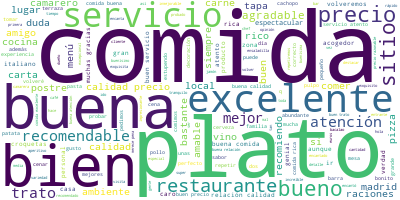

In [13]:
from wordcloud import WordCloud# Join the different processed titles together.
long_string = ','.join(list(df2['text_processed'].values))# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
wordcloud.to_image()

In [14]:
import gensim
from gensim.utils import simple_preprocess
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('spanish')
stop_words.extend(["desde", "excelente", "siempre", "bien", "aunque", "solo", "si", "bueno", "así", "muy", "mejor", "buena", "gran", "puede", "puedo", "pueden", "puedes"])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
    
data = df2["text_processed"].values.tolist()
data_words = list(sent_to_words(data))# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['quieres', 'comer', 'abundante', 'florituras', 'lugar', 'acude', 'tiempo', 'menu', 'mediodia', 'llena']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jilai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
import gensim.corpora as corpora# Create Dictionary
id2word = corpora.Dictionary(data_words)# Create Corpus
texts = data_words# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]


In [16]:
def flatten_comprehension(matrix):
    return [item for row in matrix for item in row]

In [26]:
from collections import Counter

import spacy

# Cargar el modelo de idioma en español
nlp = spacy.load('es_core_news_sm')

def es_adjetivo(palabra):
    doc = nlp(palabra)
    for token in doc:
        if token.pos_ == 'ADJ':
            return True
    return False

#frecuency of data words
word_counting = flatten_comprehension(data_words)

frecuency = Counter(word_counting)
for word, freq in frecuency.copy().items():
    if es_adjetivo(word):
        del frecuency[word]
frecuency.most_common(15)

[('comida', 383),
 ('servicio', 255),
 ('calidad', 247),
 ('precio', 241),
 ('trato', 157),
 ('platos', 150),
 ('atencion', 138),
 ('sitio', 138),
 ('restaurante', 132),
 ('ambiente', 99),
 ('menu', 90),
 ('madrid', 89),
 ('lugar', 76),
 ('amigos', 72),
 ('carta', 71)]

In [7]:
classifier = pipeline(
    "zero-shot-classification",
    model="Recognai/bert-base-spanish-wwm-cased-xnli",
    framework="pt",
)

In [8]:
result = classifier(
    "quieres comer abundante  florituras  lugar  Acude tiempo men medioda  llena",
    candidate_labels=[
        "comida",
        "servicio al cliente",
        "ambiente",
        "limpieza",
        "precio",
        "ubicación",
        "bebida",
        "personal",
        "calidad",
    ],
    hypothesis_template="Se habla sobre {} del restaurante.",
    multi_label=True,
)
result

{'sequence': 'quieres comer abundante  florituras  lugar  Acude tiempo men medioda  llena',
 'labels': ['ambiente',
  'ubicación',
  'comida',
  'precio',
  'calidad',
  'personal',
  'servicio al cliente',
  'bebida',
  'limpieza'],
 'scores': [0.6008378863334656,
  0.3162613809108734,
  0.25562068819999695,
  0.1030738577246666,
  0.0989302545785904,
  0.04597143828868866,
  0.026562552899122238,
  0.008994144387543201,
  0.008186652325093746]}